In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
url = 'https://docs.google.com/spreadsheets/d/1HcdISgCl3s4RpWkJa8m-G1JjfKzd8qf2WY2Xcw32D7U/pub?gid=1371955398&single=true&output=csv'

In [18]:
import pandas

historical_record = pandas.read_csv(url)
historical_record['Match Date'] = pandas.to_datetime(historical_record['Match Date'], infer_datetime_format=True)

In [19]:
event_dates = dict(pandas.to_datetime(
    historical_record.groupby('Event').max()['Match Date'],
    infer_datetime_format=True
))

In [20]:
import re
def normalize_name(player):
    return re.sub('[\W_]+', '', player).lower()

all_names = pandas.DataFrame({'Name': historical_record['Player 1'].append(
    historical_record['Player 2']
).unique()})
all_names['Normalized'] = all_names['Name'].apply(normalize_name)

canonical_names = {
    row[0]: row[1]['Name']
    for row in all_names.groupby(['Normalized']).first().iterrows()
}

normalized_names = {
    name: canonical_names[normalize_name(name)]
    for name in all_names['Name']
}

historical_record['Player 1'] = historical_record['Player 1'].apply(lambda n: normalized_names[n])
historical_record['Player 2'] = historical_record['Player 2'].apply(lambda n: normalized_names[n])

In [21]:
historical_record['Event Date'] = historical_record.apply(lambda row: event_dates[row['Event']], axis=1)

In [22]:
standard_format = historical_record[
    historical_record['Format\n(Team)']=='.'
][
    historical_record['Format\n(Restricted)']=='.'
]

/home/cpennington/.pyenv/versions/3.6.1/lib/python3.6/site-packages/ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [23]:
win_counts = standard_format.groupby([
    'Event Date', 'Event', 'Player 1', 'Player 2'
]).sum().fillna(0)

In [24]:
from skills import Player, Team, Match, Matches
from skills.elo import EloCalculator, EloGameInfo

game_info = EloGameInfo()
calculator = EloCalculator()

ratings = {
    p: 1500
    for p in (historical_record['Player 1'].append(historical_record['Player 2'])).unique()
}

ratings_history = []

games = historical_record.fillna(0).groupby(['Match Date', 'Event', 'Player 1', 'Player 2']).sum().reset_index().sort_values(by=['Match Date'])

for row in games.iterrows():
    p1 = row[1]['Player 1']
    p2 = row[1]['Player 2']
    for _ in range(int(row[1]['Wins 1'])):
        match = Match([[(p1, ratings[p1])], [(p2, ratings[p2])]], [1, 2])
        new_ratings = calculator.new_ratings(match, game_info)
        ratings[p1] = new_ratings.rating_by_id(p1)
        ratings[p2] = new_ratings.rating_by_id(p2)
    for _ in range(int(row[1]['Wins 2'])):
        match = Match([[(p1, ratings[p1])], [(p2, ratings[p2])]], [2, 1])
        new_ratings = calculator.new_ratings(match, game_info)
        ratings[p1] = new_ratings.rating_by_id(p1)
        ratings[p2] = new_ratings.rating_by_id(p2)
    ratings_history.extend([
        (row[1]['Match Date'], row[1]['Event'], p1, new_ratings.rating_by_id(p1) and new_ratings.rating_by_id(p1).mean),
        (row[1]['Match Date'], row[1]['Event'], p2, new_ratings.rating_by_id(p2) and new_ratings.rating_by_id(p2).mean),
    ])
    
ratings_history = pandas.DataFrame(
    ratings_history,
    columns=['Date', 'Event', 'Player', 'Rating']
)

post_tournament_ratings = ratings_history.sort_values(by=['Date', 'Event']).groupby(['Event', 'Player']).last()
ratings_history['Event Date'] = ratings_history.reset_index().apply(lambda row: event_dates[row['Event']], axis=1).values
    

# Top 20 Players by Lifetime Average Elo

In [25]:
ratings_history.groupby('Player').mean().sort_values(by=['Rating'], ascending=False)[:20]

,Rating
Player,
Niijima-San,1647.200538
deluks917,1646.018981
cpat,1640.117693
Raziek,1633.014345
Fivec,1630.104232
ntillerman,1616.115472
drnd,1615.511026
Jengajam,1612.928417
mastrblastr,1607.660755


# Top 20 Players of all time by current rating

In [26]:
ratings_history.sort_values(by=['Date']).groupby('Player').last().sort_values(by=['Rating'], ascending=False)[:20]

,Date,Event,Rating,Event Date
Player,,,,
cpat,2016-09-25,FS.com Into Oblivion,1803.986993,2016-09-25
Fusxfaranto,2017-08-09,IYL Season 5,1717.162829,2017-08-09
Djister,2016-12-01,Rook's Rock n' Rumble,1693.631480,2016-12-01
Legion,2017-06-24,Fractured Factions,1687.694902,2017-06-24
ntillerman,2016-11-26,Topanda League 2,1685.152892,2017-02-17
Niijima-San,2017-07-30,NFTT Round 6,1673.946229,2017-07-30
SirHandsome,2017-08-01,Summer Smash IV,1670.834899,2017-08-07
Caralad,2017-07-30,Solo Showdown II,1664.344781,2017-07-30
BD_Corro,2017-08-05,IYL Season 5,1656.379982,2017-08-09


# Top 20 Recently Active Players

In [27]:
import datetime

current_elo = ratings_history.sort_values(by=['Date']).groupby('Player').last()
recent_elo = current_elo[current_elo['Date'] > datetime.date.today() - datetime.timedelta(days=180)]
recent_elo.sort_values(by=['Rating'], ascending=False)[:20]

,Date,Event,Rating,Event Date
Player,,,,
Fusxfaranto,2017-08-09,IYL Season 5,1717.162829,2017-08-09
Legion,2017-06-24,Fractured Factions,1687.694902,2017-06-24
Niijima-San,2017-07-30,NFTT Round 6,1673.946229,2017-07-30
SirHandsome,2017-08-01,Summer Smash IV,1670.834899,2017-08-07
Caralad,2017-07-30,Solo Showdown II,1664.344781,2017-07-30
BD_Corro,2017-08-05,IYL Season 5,1656.379982,2017-08-09
flagrantangles,2017-08-02,Summer Smash IV,1637.694557,2017-08-07
deluks917,2017-04-29,NFTT Round 3,1633.677658,2017-04-29
thehug0naut,2017-08-09,IYL Season 5,1632.339805,2017-08-09


# Rating Trajectories of all Players over All Time

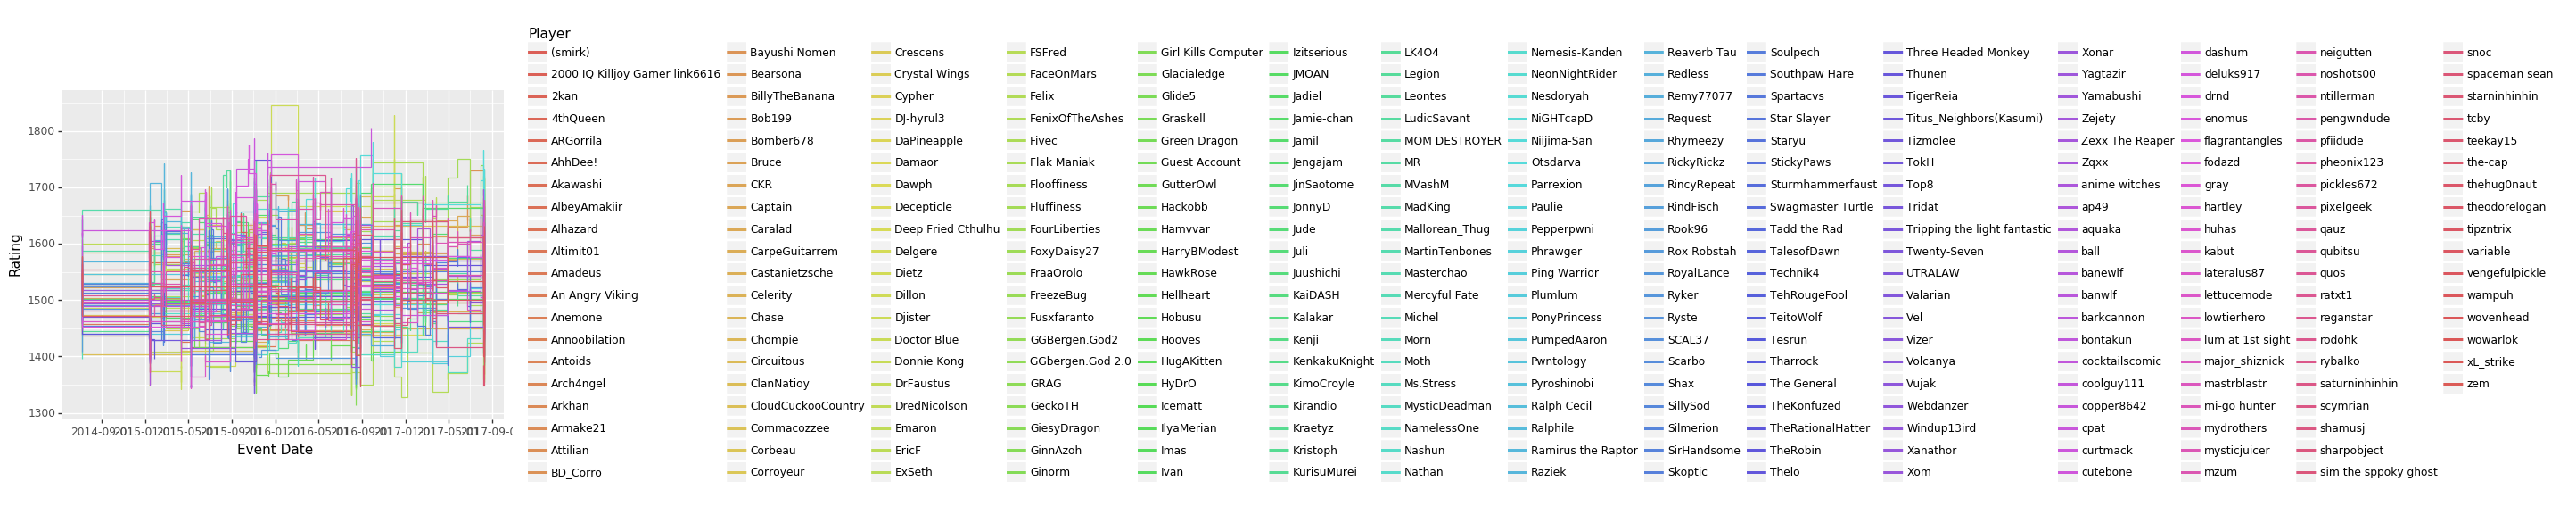

<ggplot: (8734538480125)>

In [28]:
from plotnine import *

ggplot(
    ratings_history.reset_index(),
    aes(
        x='Event Date',
        y='Rating',
        color='Player',
    )
) + geom_step()

# thehug0naut's ELO in-context plot

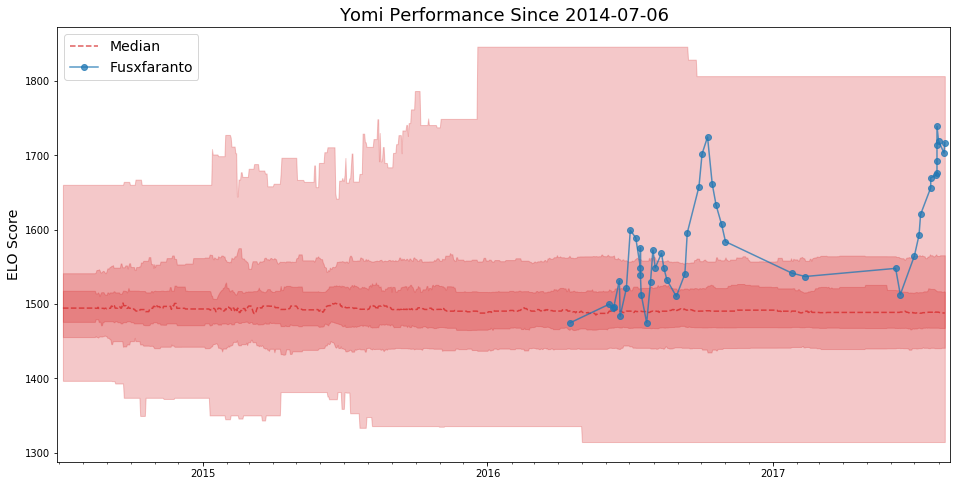

In [30]:
%matplotlib inline
from matplotlib import pyplot
from matplotlib import dates as mdates
import numpy

ratings_history["Date"] = pandas.to_datetime(ratings_history["Date"].values).to_pydatetime()

# pick some players to plot progression for, choose the colours for them here too
chosen_players = ["Fusxfaranto"]
player_colours = ["C0",]

histories = list()
for player in chosen_players:
    histories.append(ratings_history[ratings_history["Player"]==player])
    
# get the earliest and latest chart datapoints
start = ratings_history["Date"].min()
end = ratings_history["Date"].max()

# make a list of all dates in-between
dates = pandas.date_range(start, end, freq="D").to_pydatetime()

# define the contours we want to plot, keep it odd so there's a median line in the centre
contours = numpy.linspace(0, 1, 7)
median = len(contours) // 2

# make an array to store our contour results
performance_contours = numpy.zeros([len(contours), len(dates)])

# get each player's most up-to date rating for each date the chart has run for, then pick out the desired quantiles
for d, date in enumerate(dates):
    last_ratings = ratings_history[ratings_history["Date"]<=date].groupby("Player")["Rating"].agg("last")
    for c, contour in enumerate(contours):
        performance_contours[c, d] = last_ratings.quantile(contour)

# plot the player a ratings quantile map with median line
fig, ax = pyplot.subplots(1,1,figsize=([16,8]))
for c in range(median):
    ax.fill_between(dates, performance_contours[c], performance_contours[-(1+c)], color="C3", alpha=1/(median+1))
ax.plot_date(dates, performance_contours[median], "C3--", alpha=0.75, label="Median")

# plot curves for each player of interest
for player, phistory, pcolour in zip(chosen_players, histories, player_colours):
    ax.plot_date(pandas.to_datetime(phistory["Date"].values).to_pydatetime(),
                 phistory["Rating"], "o-", color=pcolour, alpha=0.75, label=player)
    
# pick out years for major tick marks and months for minors
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_minor_locator(mdates.MonthLocator())
ax.set_xlim(start-datetime.timedelta(days=7), end+datetime.timedelta(days=7))

# switch on legend and add title
ax.legend(fontsize=14, loc=2)
ax.set_title("Yomi Performance Since {}".format(start.date()), size=18)
ax.set_ylabel("ELO Score", size=14)
fig.patch.set_facecolor('white')